In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import warnings
import os
import shutil
warnings.filterwarnings("ignore")
from interval_model.NNIG import nn_fuzzy_information_granular
from interval_model.NNIG1209 import nn_fuzzy_information_granular1209
from interval_model.FIG import fuzzy_information_granular
from interval_model.lube import lube
from util.parameters import Parameters
from tqdm import tqdm
from util.parameters import Parameters
import torch


In [55]:
params = Parameters()
fig_day =11
lookback_pattern = 7
look_forward = 3

epochs = 100
n_country = 42
node_features = params.node_fea
lr = params.lr
weight_decay = params.weight_decay
print('fig_day         :',fig_day)
print('lookback_pattern:',lookback_pattern)
print('look_forward    :',look_forward)

fig_day         : 11
lookback_pattern: 7
look_forward    : 3


In [56]:
country_data_case = pd.read_csv("dataset/第三章输入数据.csv", delimiter=",")
country_data_case = country_data_case[['MEX', 'GBR', 'ITA', 'FRA', 'ESP', 'COL',
       'ARG', 'ZAF', 'IDN', 'UKR', 'TUR', 'CAN', 'CHL', 'BEL', 'HUN', 'ECU',
       'BGR', 'PHL', 'BOL', 'CHE', 'JPN', 'BGD', 'TUN', 'MAR', 'GRC', 'GTM',
       'SAU', 'HRV', 'KAZ', 'SRB', 'MDA', 'IRL', 'HND', 'PRY', 'SVN', 'GEO',
       'AZE', 'LTU', 'ARM', 'DOM', 'DZA', 'NPL']].T

country_name=['MEX', 'GBR', 'ITA', 'FRA', 'ESP', 'COL',
       'ARG', 'ZAF', 'IDN', 'UKR', 'TUR', 'CAN', 'CHL', 'BEL', 'HUN', 'ECU',
       'BGR', 'PHL', 'BOL', 'CHE', 'JPN', 'BGD', 'TUN', 'MAR', 'GRC', 'GTM',
       'SAU', 'HRV', 'KAZ', 'SRB', 'MDA', 'IRL', 'HND', 'PRY', 'SVN', 'GEO',
       'AZE', 'LTU', 'ARM', 'DOM', 'DZA', 'NPL']

In [57]:
nnig = nn_fuzzy_information_granular1209(country_data_case)
FIG = fuzzy_information_granular(country_data_case.T.values, fig_day)

In [58]:
nnig_lower_np,nnig_med_np,nnig_upper_np = nnig.get_FIG_result(country_data_case,fig_day)
fig_lower_np, fig_med_np, fig_upper_np = FIG.get_FIG_result(fig_day)
lube_med_np, lube_lower_np, lube_upper_np = lube(country_data_case.T.values, fig_day)


In [59]:
from scipy.stats import shapiro, anderson
from scipy.stats import wilcoxon
def normal_wilcoxon(nnig_upper_np,nnig_lower_np,fig_upper_np,fig_lower_np):
    nnig_width_set, fig_width_set= [],[]
    
    #进行处理
    for i in range(42):
        nnig_width_set.append(list(nnig_upper_np[i]-nnig_lower_np[i]))
        fig_width_set.append(list(fig_upper_np[i]-fig_lower_np[i]))
    nnig_width_set = np.array(nnig_width_set)
    fig_width_set  = np.array(fig_width_set)
    
    p_value_set = []
    #判断正态分布
    for i in range(42):
        nnig_sw, nnig_p = shapiro(nnig_width_set[i])
        fig_sw, fig_p = shapiro(fig_width_set[i])
        if fig_p<0.05 and nnig_p<0.05:
            statistic, p_value = wilcoxon(nnig_width_set[i], fig_width_set[i])
        p_value_set.append(p_value)
    #如果p-value小于显著性水平（通常选择0.05），
    #则可以得出结论：这两种方法在得到的结果上存在显著差异。
    # 使用任意和操作符来检查是否有某个数大于 0.05
    count = 0
    for value in p_value_set:
        if value>0.05:
            count = count + 1
    return count,p_value_set

In [60]:
normal_wilcoxon(nnig_upper_np,nnig_lower_np,fig_upper_np,fig_lower_np)

(0,
 [3.9282745831103867e-10,
  5.104491491718049e-09,
  1.1443154727963905e-10,
  6.231432676058093e-11,
  5.113786584683448e-13,
  9.86987564219973e-10,
  1.4194995737499074e-08,
  2.6781989122125035e-07,
  1.2687102204033072e-10,
  1.1364903756429101e-07,
  1.7917069827628388e-07,
  7.075725805273177e-11,
  9.498414335245212e-11,
  7.280881406707777e-08,
  7.863415867657672e-09,
  4.807540089370922e-10,
  1.0283593115308368e-10,
  4.2596469828463167e-10,
  2.2263622547975765e-10,
  0.0010783237624948142,
  2.55510608922137e-10,
  4.27718234220772e-09,
  0.002249925054146386,
  3.6945689265359235e-11,
  1.8278611114425503e-10,
  8.734003900758252e-13,
  3.5780485256338587e-10,
  8.475727123513258e-10,
  3.5624326383419157e-10,
  5.6412942666074336e-09,
  1.742088718600998e-10,
  0.0002857056852713294,
  2.839684223214864e-12,
  1.572950757315325e-11,
  1.9088521598671376e-09,
  0.000352805057847011,
  1.9051932418612805e-07,
  1.1057742061270981e-09,
  7.742064568345251e-11,
  6.0199

In [61]:
normal_wilcoxon(nnig_upper_np,nnig_lower_np,lube_upper_np,lube_lower_np)

(1,
 [2.0467829267085243e-10,
  7.696953596806668e-08,
  3.1195726421096834e-08,
  9.964655487495174e-09,
  2.172609107374731e-07,
  0.0010385920250355327,
  7.869192335558794e-06,
  3.368787216620455e-09,
  7.714417591460788e-10,
  4.857545401928289e-11,
  2.128988230607635e-07,
  3.5913427256741414e-06,
  1.5618509835120078e-10,
  0.0009747852065230472,
  1.2150877674255681e-05,
  1.0284468969723773e-05,
  6.034178130232975e-10,
  6.482383775893991e-09,
  1.227294551414784e-06,
  1.6908639249168828e-07,
  1.7189970297220765e-08,
  1.5719715212476858e-09,
  0.026164501023204514,
  2.409314678039228e-11,
  9.571381987166552e-06,
  1.4327239669698262e-13,
  1.0533238773149684e-05,
  2.3187364268671275e-08,
  0.0012350128077846018,
  3.682291649685637e-06,
  1.502873420509415e-05,
  7.127644097554079e-05,
  0.33463443480412636,
  0.0031053548559087647,
  3.6101369975026263e-12,
  0.0032200227587543587,
  7.353445762623828e-06,
  1.2710593598954166e-08,
  1.57479448707178e-07,
  5.6258043

In [62]:
normal_wilcoxon(fig_upper_np,fig_lower_np,lube_upper_np,lube_lower_np)

(24,
 [0.0009044302465891871,
  0.07406904012430741,
  0.29325740211708196,
  0.1119594518929304,
  0.27908995743184006,
  0.16370815070347544,
  0.00036800591362011524,
  0.0003608216406405508,
  0.07748359034194098,
  1.227294551414784e-06,
  0.00020974178214635452,
  0.0050952763635447335,
  3.218603325005204e-05,
  0.38438443285400525,
  0.31643081884760216,
  0.2178706754768558,
  5.8785811812819314e-05,
  0.1598263127850278,
  0.30165757290889095,
  0.0010087256950229737,
  0.026566162453471855,
  0.000174322023717003,
  0.8157759584059425,
  0.00010765405731294574,
  0.9093156718818521,
  6.111396164034835e-08,
  0.12099284499941095,
  0.000682912197767072,
  0.46295032467193364,
  0.2746479178959915,
  0.19023974370645824,
  0.3201960733473518,
  6.169828900867057e-07,
  0.10843015929603325,
  6.548613503056576e-07,
  0.8077451324835785,
  0.643095871810966,
  0.001158952835608957,
  0.08279999326025834,
  0.8197986963336813,
  0.018515286808962413,
  0.22570285889093133])

-------------fig_day: 11 -------------
NNIG & FIG : 
0
NNIG & LUBE : 
1
FIG & LUBE : 
24


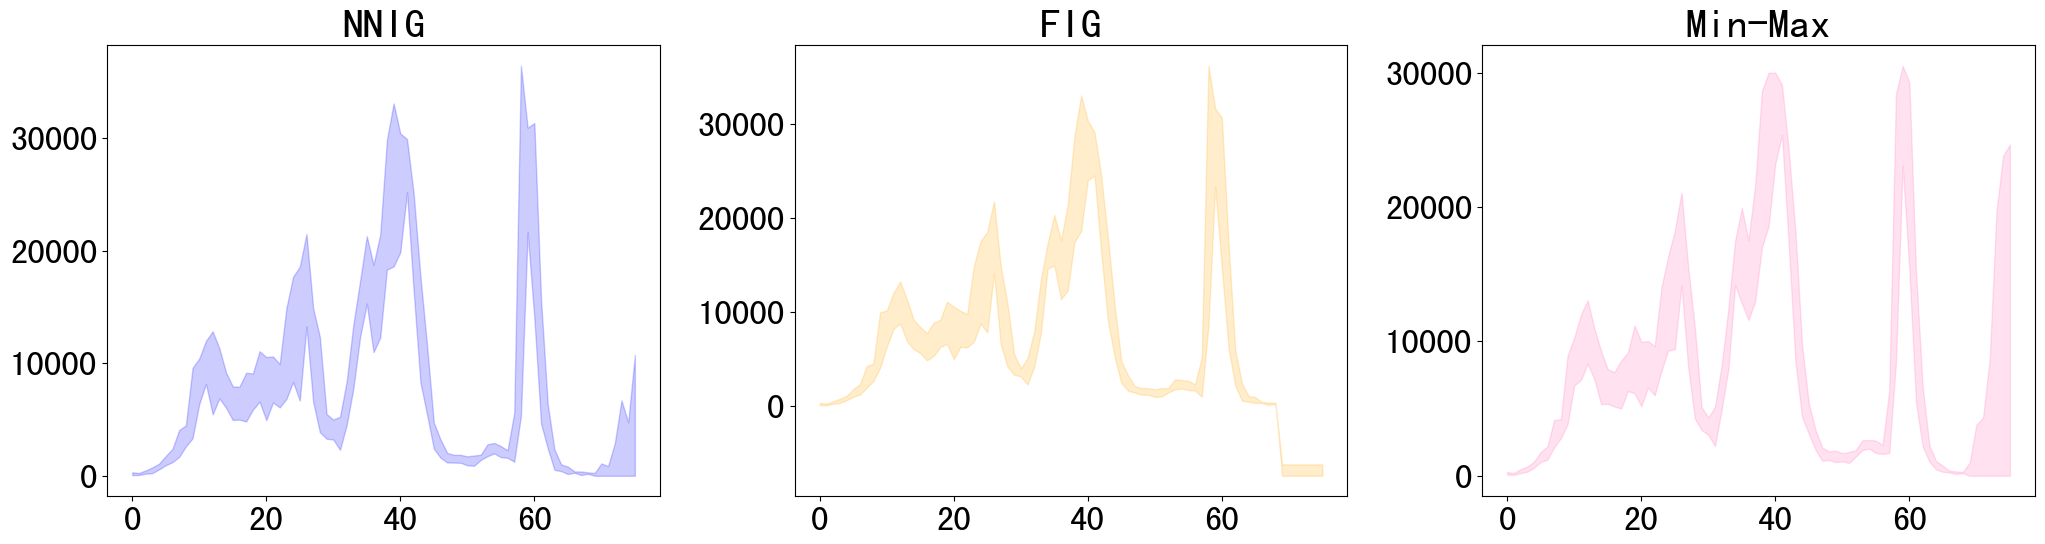

-------------fig_day: 9 -------------
NNIG & FIG : 
0
NNIG & LUBE : 
0
FIG & LUBE : 
12


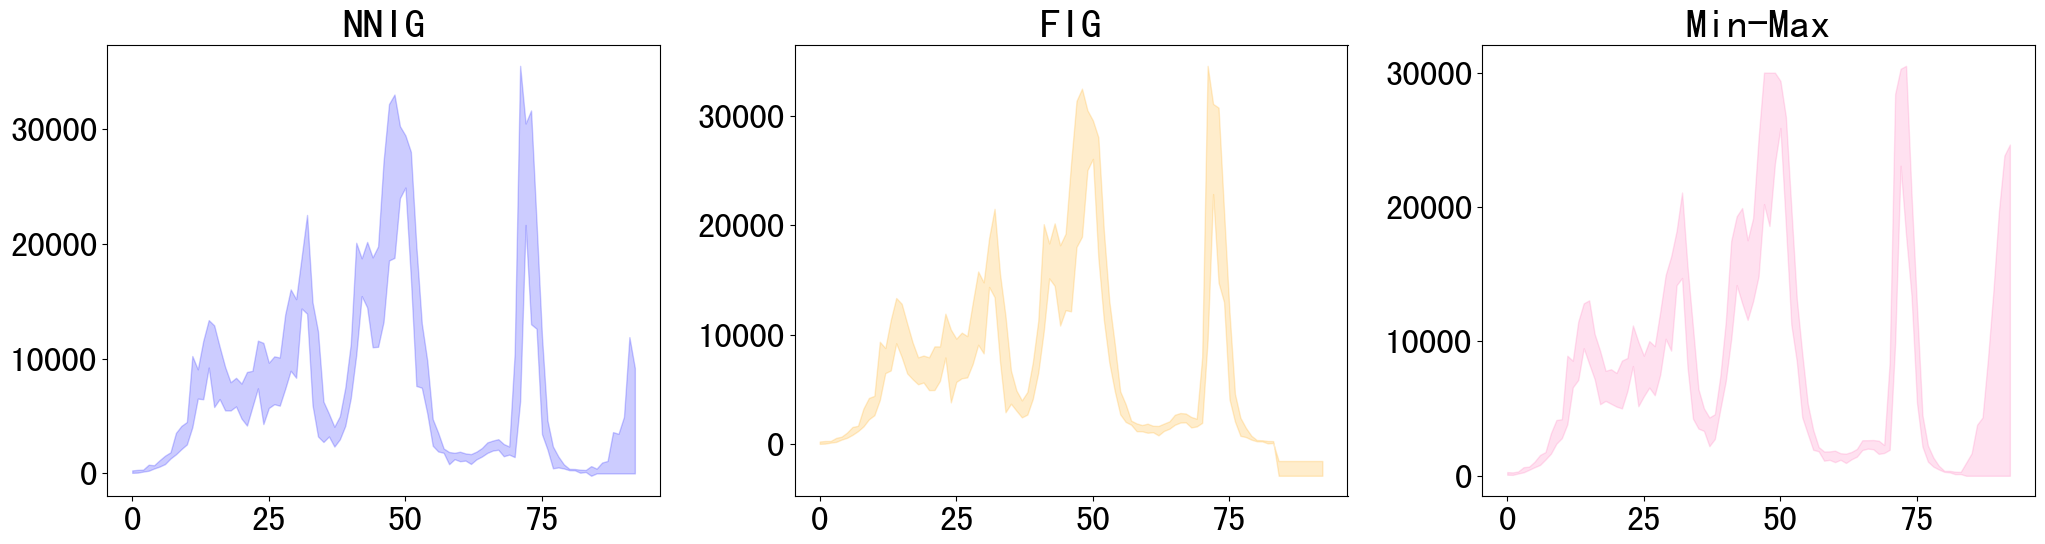

-------------fig_day: 7 -------------
NNIG & FIG : 
0
NNIG & LUBE : 
0
FIG & LUBE : 
4


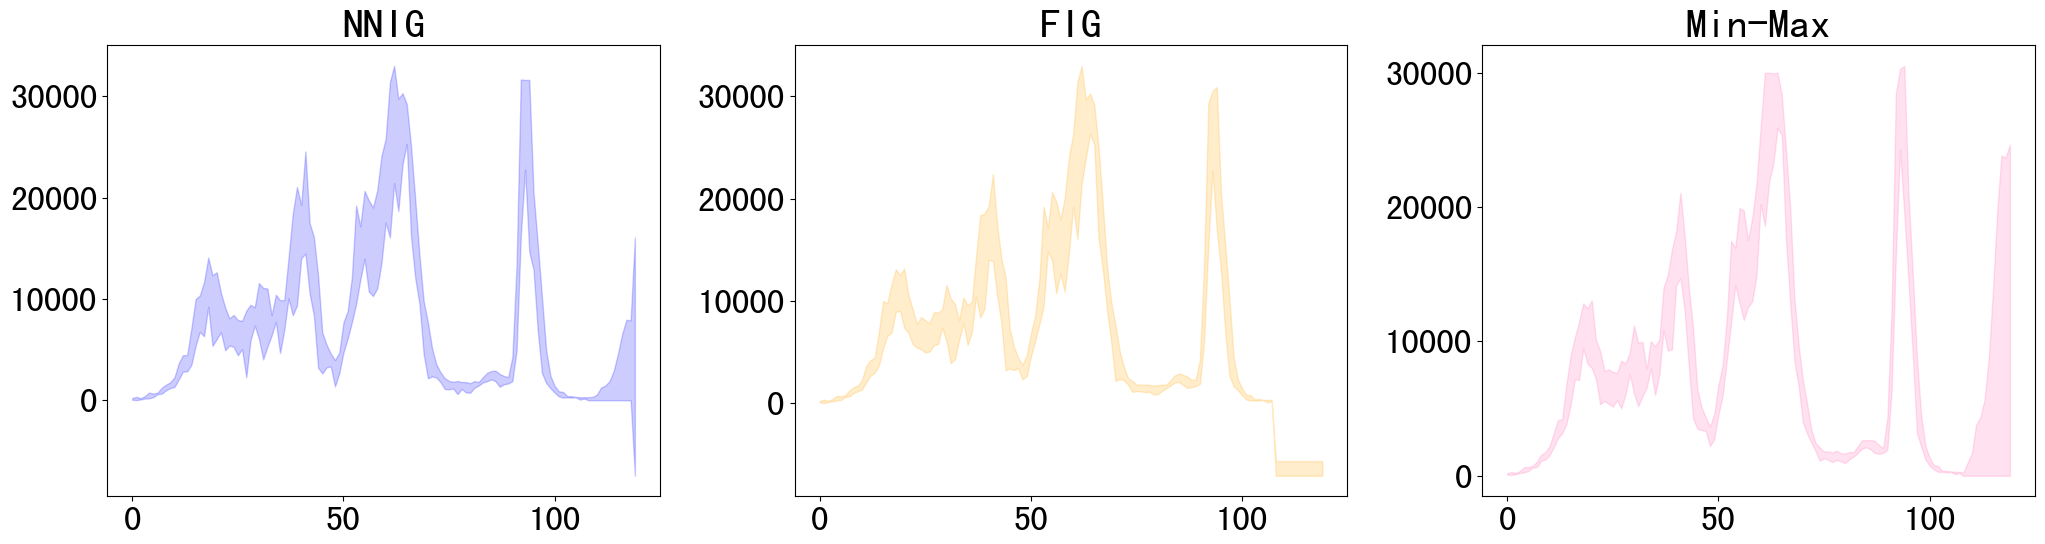

-------------fig_day: 5 -------------
NNIG & FIG : 
0
NNIG & LUBE : 
0
FIG & LUBE : 
2


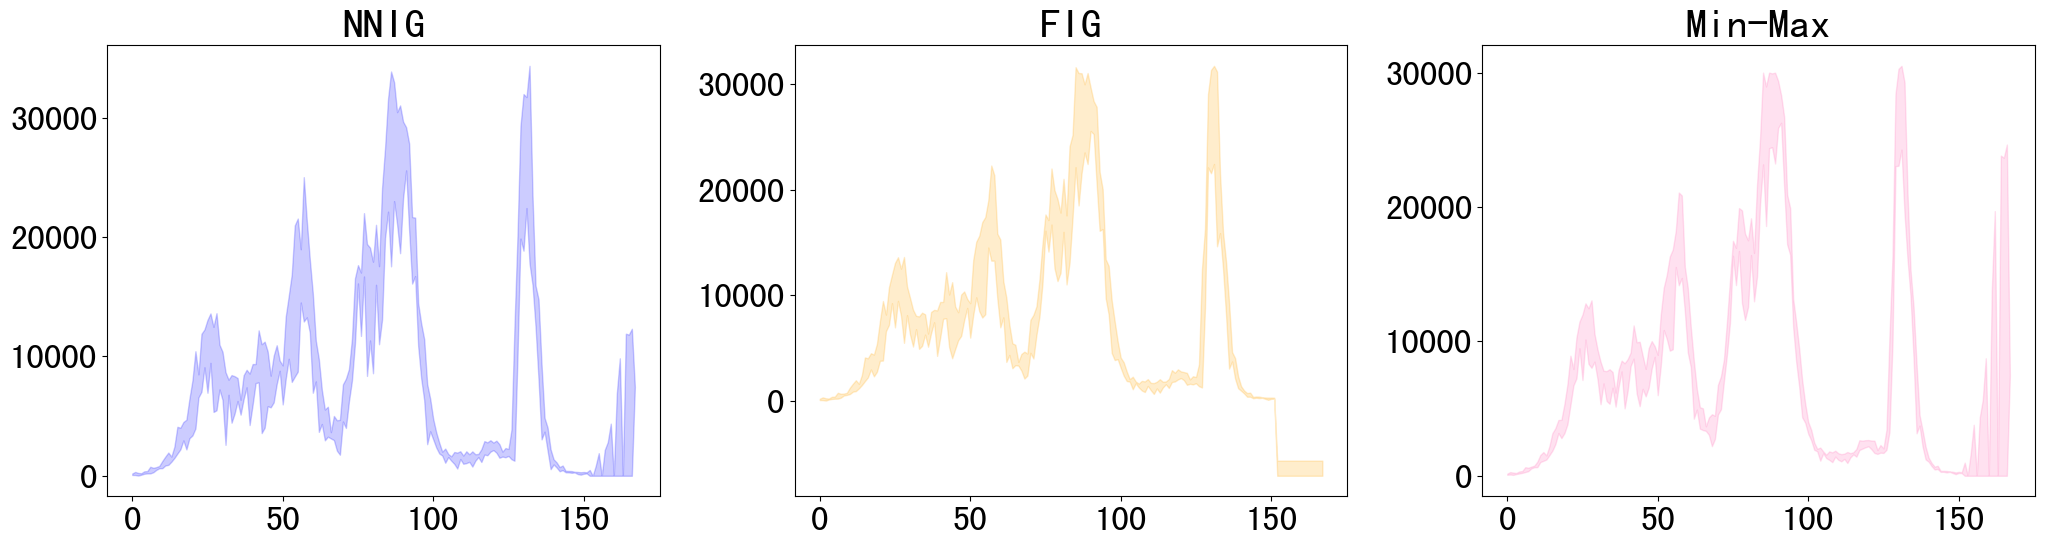

In [71]:
fig_days = [11,9,7,5]
lookback_patterns = [7,5,3]
look_forwards = [3,1]
for fig_day in fig_days:
    print('-------------fig_day:',fig_day,'-------------')
    nnig = nn_fuzzy_information_granular1209(country_data_case)
    FIG = fuzzy_information_granular(country_data_case.T.values, fig_day)
    nnig_lower_np,nnig_med_np,nnig_upper_np = nnig.get_FIG_result(country_data_case,fig_day)
    fig_lower_np, fig_med_np, fig_upper_np = FIG.get_FIG_result(fig_day)
    lube_med_np, lube_lower_np, lube_upper_np = lube(country_data_case.T.values, fig_day)
    print('NNIG & FIG : ')
    count,_ = normal_wilcoxon(nnig_upper_np,nnig_lower_np,fig_upper_np,fig_lower_np)
    print(count)

    print('NNIG & LUBE : ')
    count,_ = normal_wilcoxon(nnig_upper_np,nnig_lower_np,lube_upper_np,lube_lower_np)
    print(count)
    
    count,_ = normal_wilcoxon(fig_upper_np,fig_lower_np,lube_upper_np,lube_lower_np)
    print('FIG & LUBE : ')
    print(count)
    
    fig, axes = plt.subplots(1, 3, figsize=(21, 6)) 
    # 绘制第一个子图
    axes[0].set_title('NNIG')  # 设置子图的标题  
    # axes[0].plot(nnig_med_np[35], label='NNIG Median')
    axes[0].fill_between(range(len(nnig_lower_np[25])), nnig_lower_np[10], nnig_upper_np[5], alpha=0.2, color='blue')
    # axes[0].savefig('./dataset/output/nnig.png')#
    axes[1].set_title('FIG')  # 设置子图的标题  
    # axes[1].plot(fig_med_np[0], label='FIG Median',color = 'orangered')
    axes[1].fill_between(range(len(fig_lower_np[25])), fig_lower_np[5], fig_upper_np[5], alpha=0.2, color='orange')
    # axes[1].savefig('./dataset/output/fig.png')#
    axes[2].set_title('Min-Max')  # 设置子图的标题  
    # axes[2].plot(lube_med_np[0], label='Min-Max Median',color = 'hotpink')
    axes[2].fill_between(range(len(lube_lower_np[25])), lube_lower_np[5], lube_upper_np[5], alpha=0.2, color='hotpink')
    # axes[2].savefig('./dataset/output/lube.png')#

    plt.tight_layout()
    plt.rcParams.update({'font.size': 25})
    # plt.savefig('./dataset/output/nnig.png')#
    plt.show()